# Protest classification turkish protest

In [379]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

In [251]:
df = pd.read_csv('Data/GT_Data_extra_aggregated.csv')

In [252]:
df_protest = df[['text','protest']]

In [301]:
d = df[df_protest['protest']==1]
len(d)

418

In [253]:
pipeline_protest = Pipeline([
    ('vectorizer',  CountVectorizer()),
    ('classifier',  MultinomialNB()) ])

pipeline_protest.fit(df_protest['text'].values, df_protest['protest'].values)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [260]:
def k_fold_cross_validation(pipeline, df,label, n_folds):
    k_fold = KFold(n=len(df), n_folds=n_folds)
    scores = []
    confusion = numpy.array([[0, 0], [0, 0]])
    for train_indices, test_indices in k_fold:
        train_text = df.iloc[train_indices]['text'].values
        train_y = df.iloc[train_indices][label].values

        test_text = df.iloc[test_indices]['text'].values
        test_y = df.iloc[test_indices][label].values

        pipeline.fit(train_text, train_y)
        predictions = pipeline.predict(test_text)

        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label=1)
        scores.append(score)

    print('Total emails classified:', len(df))
    print('Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusion)

In [290]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [346]:
pipeline_protest_NB = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english', min_df=10, lowercase=True, binary=True)),
    ('classifier',  MultinomialNB()) ])

#pipeline_protest_NB.fit(df_protest['text'], df_protest['protest'])

k_fold_cross_validation(pipeline_protest_NB, df_protest, 'protest', 6)

Total emails classified: 1000
Score: 0.851627880906
Confusion matrix:
[[517  65]
 [ 61 357]]


In [345]:
pipeline_protest_BNB = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english', min_df=10,  lowercase=True, binary=True)),
    ('classifier',  BernoulliNB(binarize=0.0)) ])

k_fold_cross_validation(pipeline_protest_BNB, df_protest, 'protest', 10)

Total emails classified: 1000
Score: 0.836591643038
Confusion matrix:
[[515  67]
 [ 66 352]]


In [347]:
pipeline_protest_SGD = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english', min_df=10, lowercase=True, binary=True)),
    ('classifier',  SGDClassifier(random_state=42)) ])

k_fold_cross_validation(pipeline_protest_SGD, df_protest, 'protest',10)

/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Total emails classified: 1000
Score: 0.816732111347
Confusion matrix:
[[473 109]
 [ 52 366]]


In [265]:
X_train, X_test, y_train, y_test = train_test_split(df_protest['text'], 
                                                    df_protest['protest'], 
                                                    test_size=0.33, 
                                                    random_state=42)

In [373]:
print(y_train.shape)
print(y_test.shape)

(670,)
(330,)


In [266]:
def plot_precision_recall(precision, recalls):
    plt.plot(recalls, precision, "b--", label="")
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="upper left")
    plt.ylim([0,1])

In [348]:
#predicted scores
scores = cross_val_score(pipeline_protest_NB, X_train, y_train, cv =10)
print(scores.mean())
print(scores.std())

0.886505307686
0.0363399384623


In [349]:
#predicted scores
scores = cross_val_score(pipeline_protest_SGD,X_train, y_train, cv =10)
print(scores.shape)
print(scores.mean())
print(scores.std())

(10,)
0.861507303057
0.0579968912527


In [350]:
#decision scores to find the threshold between recall and precisions
y_scores = cross_val_predict(pipeline_protest_SGD, X_train, y_train, cv =10,method="decision_function")

In [378]:
y_scores2 = pipeline_protest_SGD.fit(X_train, y_train).decision_function(X_test)

In [351]:
#work around bug in 0.19
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [352]:
print(y_scores.shape)
print(df_protest['protest'].values.shape)

(670,)
(1000,)


In [370]:
roc_auc = roc_auc_score(y_train, y_scores)
print(roc_auc)

0.896680343156


In [376]:
roc_auc = roc_auc_score(y_test, y_scores2)
print(roc_auc)

0.852602708197


In [353]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [354]:
print(precisions.shape, recalls.shape, thresholds.shape)

(561,) (561,) (560,)


/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


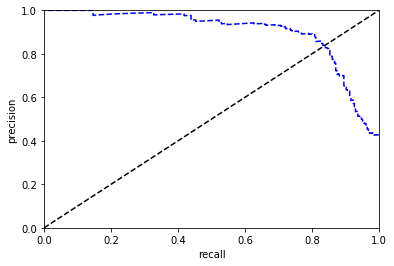

In [355]:
plot_precision_recall(precisions, recalls)
plt.show()

In [356]:
fpr, tpr , th = roc_curve(y_train, y_scores)

In [357]:
print(fpr.shape, tpr.shape, th.shape)

(206,) (206,) (206,)


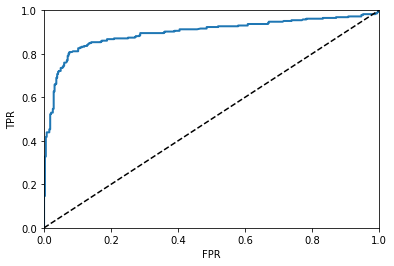

In [358]:
plot_roc_curve(fpr, tpr)
plt.show()

In [359]:
print(precisions[:-1].shape, recalls[:-1].shape, thresholds.shape)

(560,) (560,) (560,)


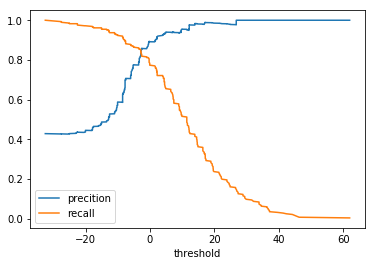

In [364]:
plt.plot(thresholds, precisions[:-1], '-', label='precition')
plt.plot(thresholds, recalls[:-1], '-', label='recall')
plt.xlabel("threshold")
plt.legend()
plt.show()

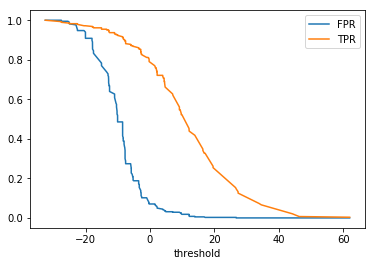

In [365]:
plt.plot(th, fpr, '-', label='FPR')
plt.plot(th, tpr, '-', label='TPR')
plt.xlabel("threshold")
plt.legend()
plt.show()

/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


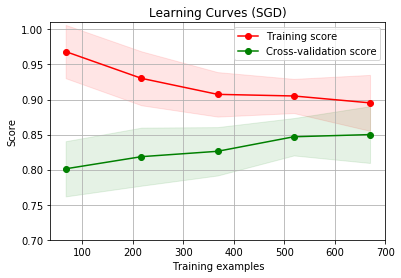

In [344]:
title = "Learning Curves (SGD)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.33, random_state=0)
count_vect = CountVectorizer(stop_words='english', min_df=10, lowercase=True, binary=True)
X_train_counts = count_vect.fit_transform(df_protest['text'].values)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
estimator =  SGDClassifier(random_state=42)
plt = plot_learning_curve(estimator, title, X_train_counts, df_protest['protest'].values, ylim=(0.7, 1.01), cv=cv, n_jobs=10)
plt.show()

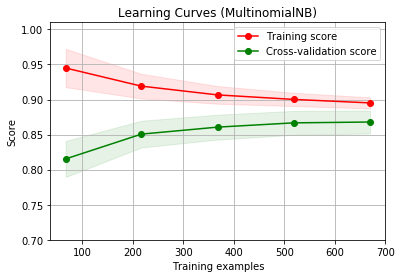

In [343]:
title = "Learning Curves (MultinomialNB)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.33, random_state=0)
count_vect = CountVectorizer(stop_words='english', min_df=10, lowercase=True, binary=True)
X_train_counts = count_vect.fit_transform(df_protest['text'].values)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
estimator =  MultinomialNB()
plt = plot_learning_curve(estimator, title, X_train_counts, df_protest['protest'].values, ylim=(0.7, 1.01), cv=cv, n_jobs=10)
plt.show()

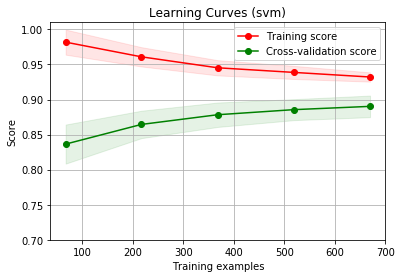

In [342]:
title = "Learning Curves (svm)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.33, random_state=0)
count_vect = CountVectorizer(stop_words='english', min_df=10, lowercase=True, binary=True)
X_train_counts = count_vect.fit_transform(df_protest['text'].values)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
estimator =  SVC(kernel='linear', gamma=2)
plt = plot_learning_curve(estimator, title, X_train_counts, df_protest['protest'].values, ylim=(0.7, 1.01), cv=cv, n_jobs=10)
plt.show()

In [317]:
count_vect = CountVectorizer(stop_words='english', min_df=10)
X_train_counts = count_vect.fit_transform(df_protest['text'].values).toarray()
vocab = np.array(count_vect.get_feature_names())
len(vocab)

111

In [367]:
print(count_vect.get_feature_names())

['0000', '20', '2013', 'ago', 'akp', 'amp', 'ankara', 'anti', 'arrested', 'attack', 'bacon', 'bbc', 'bbcbreaking', 'bbcworld', 'benjaminharvey', 'citizens', 'city', 'clashes', 'cnn', 'come', 'coming', 'country', 'crackdown', 'crowd', 'day', 'days', 'defending', 'democracy', 'demonstrators', 'direnankara', 'direngezi', 'direngezipark', 'direngeziparki', 'don', 'end', 'erdogan', 'friends', 'gas', 'gezi', 'gezipark', 'going', 'good', 'government', 'happening', 'heart', 'help', 'http', 'https', 'international', 'istanbul', 'jun', 'just', 'know', 'let', 'like', 'live', 'love', 'media', 'minister', 'need', 'new', 'news', 'occupy', 'occupygezi', 'occupyturkey', 'park', 'peaceful', 'people', 'photo', 'pm', 'police', 'prime', 'protest', 'protesters', 'protesting', 'protestors', 'protests', 'reuters', 'revolution', 'right', 'rights', 'rt', 'say', 'says', 'solidarity', 'square', 'standing', 'state', 'stop', 'street', 'support', 'syria', 'taksim', 'tayyip', 'tear', 'teargas', 'thousands', 'time', 

In [386]:
random = np.random.RandomState(seed=0)
E = random.normal(size=(len(df_protest['text'].values), 2200))

# Add noisy data to the informative features for make the task harder
X = np.c_[df_protest['text'].values, E]

#svm = SVC(kernel='linear')
cv = StratifiedKFold(2)

score, permutation_scores, pvalue = permutation_test_score(
    pipeline_protest_SGD, df_protest['text'].values, df_protest['protest'].values, scoring="roc_auc", cv=cv, n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))


Classification score 0.832527664052 (pvalue : 0.00990099009901)


In [382]:
permutation_scores

array([ 0.552,  0.475,  0.528,  0.566,  0.453,  0.474,  0.528,  0.501,
        0.462,  0.45 ,  0.524,  0.515,  0.422,  0.504,  0.474,  0.524,
        0.479,  0.525,  0.599,  0.509,  0.509,  0.525,  0.523,  0.508,
        0.463,  0.531,  0.523,  0.534,  0.52 ,  0.505,  0.468,  0.491,
        0.525,  0.543,  0.535,  0.494,  0.528,  0.56 ,  0.489,  0.526,
        0.51 ,  0.542,  0.525,  0.46 ,  0.496,  0.513,  0.514,  0.536,
        0.553,  0.518,  0.533,  0.583,  0.49 ,  0.546,  0.492,  0.556,
        0.559,  0.473,  0.496,  0.528,  0.502,  0.537,  0.568,  0.539,
        0.487,  0.488,  0.491,  0.526,  0.45 ,  0.524,  0.562,  0.5  ,
        0.494,  0.541,  0.524,  0.529,  0.444,  0.469,  0.549,  0.495,
        0.555,  0.509,  0.518,  0.541,  0.505,  0.459,  0.481,  0.569,
        0.477,  0.497,  0.532,  0.543,  0.553,  0.473,  0.519,  0.56 ,
        0.518,  0.532,  0.465,  0.516])

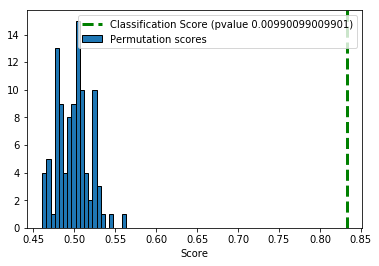

In [387]:
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
# BUG: vlines(..., linestyle='--') fails on older versions of matplotlib
# plt.vlines(score, ylim[0], ylim[1], linestyle='--',
#          color='g', linewidth=3, label='Classification Score'
#          ' (pvalue %s)' % pvalue)
# plt.vlines(1.0 / n_classes, ylim[0], ylim[1], linestyle='--',
#          color='k', linewidth=3, label='Luck')
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)


plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()